In [236]:
# ported directly from the class notebook
function ode_rkexplicit(f, u0, A, b, tfinal, h, order; tol=1e-2, adaptive=true)
    c = sum(A, 2)
    u = copy(u0)
    t = 0
    hist = []
    work = 0
    while t < tfinal
        if tfinal - t < 1.01*h
            h = tfinal - t
            tnext = tfinal
        else
            tnext = t + h
        end
        h = min(h, tfinal-t)
        fY = zeros(length(u0), length(c))
        for i in 1:length(c)
            Yi = copy(u)
            for j in 1:i
                Yi += h * A[i,j] * fY[:,j]
            end
            fY[:,i] = f(t + h*c[i], Yi)
        end
        work += 1
        h_next = h
        if adaptive
            eloc = norm(h * fY *(b[1,:] - b[2,:]))
            ratio = (tol/eloc)^(1/order)
            if ratio > 1
                h_next = h * ratio * .9
            else
                h = h * ratio * .9
                continue
            end
        end
        u += h * fY * b[1,:]
        h = h_next
        t = tnext
        push!(hist, (t, copy(u)))
    end
    hist, work
end

rk_butcher_4() = ([ 0  0 0 0
                   .5  0 0 0
                    0 .5 0 0
                    0  0 1 0],
                  [1/6 1/3 1/3 1/6], 3)

rk_butcher_bs3() = ([0     0   0 0
                     1/2   0   0 0
                     0   3/4   0 0
                     2/9 1/3 4/9 0],
                    [2/9  1/3 4/9 0
                     7/24 1/4 1/3 1/8], 3)

rk_butcher_bs3 (generic function with 1 method)

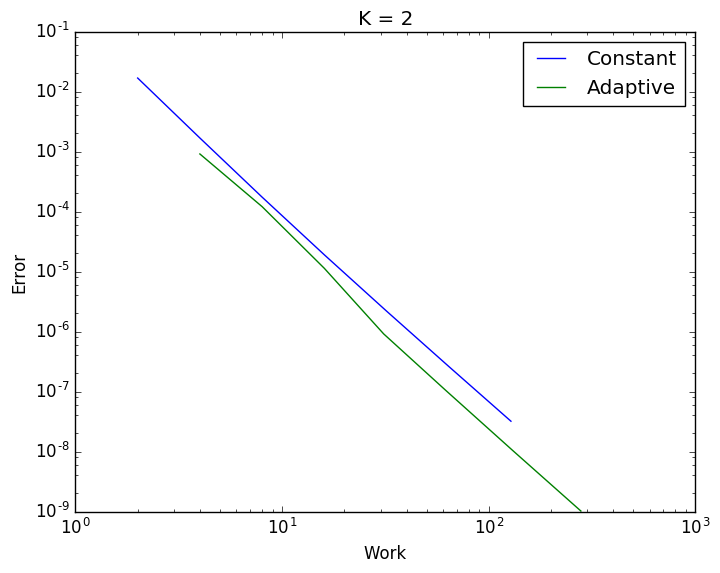

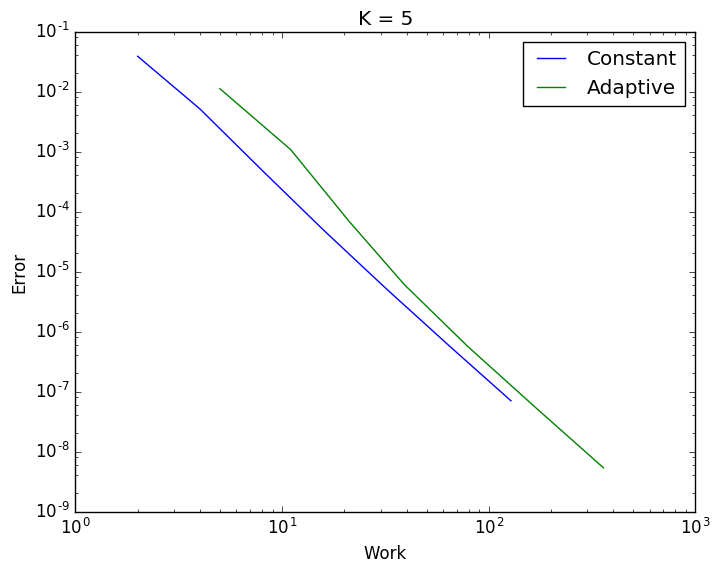

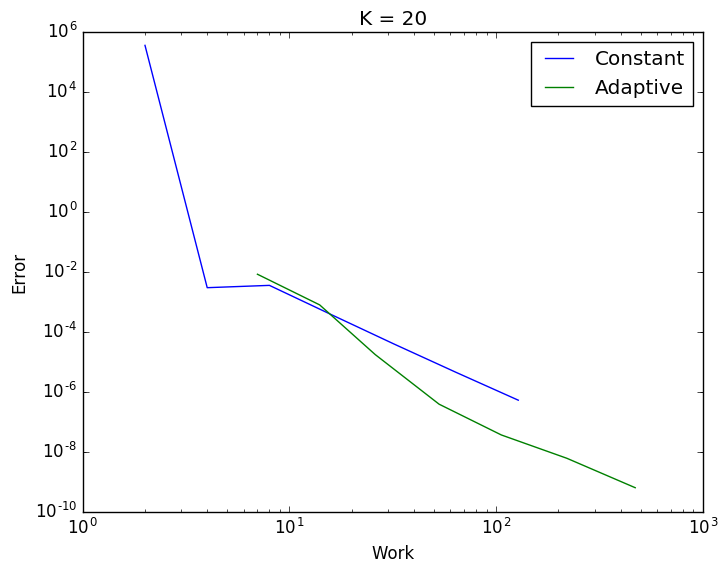

In [246]:
using PyPlot

A, b, order = rk_butcher_bs3()
A_rk4, b_rk4, _ = rk_butcher_4()
k = 2
for k in [2,5,20]
    f(t, u) = [u[2], k * (1 - u[1]^2) * u[2] - u[1]]
    initial = [1, 1]
    #tol = 1e-3
    #hist_adaptive, work_adaptive = ode_rkexplicit(f, ones(2), A, b, 1, .1, order, tol=tol, adaptive=true)
    #hist_normal, work_normal = ode_rkexplicit(f, ones(2), A, b, 1, .1, order, adaptive=false)
    hist_accurate, _ = ode_rkexplicit(f, initial, A_rk4, b_rk4, 1, 1e-6, order; adaptive=false)

    function error_estimate(hist, hist_accurate)
        maximum(abs.(hist[end][2] - hist_accurate[end][2]))
    end

    function plot_problem(hist, label, style, color)
        times = getindex.(hist,1)
        u0s = getindex.(getindex.(hist,2),1) # ugly, just want unzip
        u1s = getindex.(getindex.(hist,2),2)
        plot(times, u0s, style, label=label, color=color)
        plot(times, u1s, style, color=color)
    end

    #plot_problem(hist_adaptive, "adaptive", "o", "r")
    #plot_problem(hist_normal, "constant", "o", "g")
    #plot_problem(hist_accurate, "ground truth", "-", "b")
    #legend(loc="bottom left")

    adaptive = map(10.0.^(-8:-2)) do tol
        hist, work = ode_rkexplicit(f, initial, A, b, 1, .1, order, tol=tol, adaptive=true)
        error_estimate(hist, hist_accurate), work
    end

    constant = map(.5.^(1:7)) do h
        hist, work = ode_rkexplicit(f, initial, A, b, 1, h, order, adaptive=false)
        error_estimate(hist, hist_accurate), work
    end

    figure()
    title("K = $k")
    loglog(getindex.(constant,2), getindex.(constant,1), label="Constant")
    loglog(getindex.(adaptive,2), getindex.(adaptive,1), label="Adaptive")
    legend()
    xlabel("Work")
    ylabel("Error")
end

# Conclusions

This problem is highly dependent on initial conditions. Many choices of initial conditions cause the solvers to blow up. For solvable initial conditions, constant and adaptive step sizes are approximately equal (in terms of work and accuracy) for small values of k. For large values of k, adaptive steps appear to be better.